In [1]:
import torch
import numpy as np
import os
import re
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

### Different datasets

In [2]:
p = '/scratch/users/jpierre'
os.listdir(p)

['mew_0.01',
 'mew_noise',
 'mew_noise_0.01',
 'mew',
 'mew_0.01_bis',
 'mew_0.001_noisy',
 'mew_0.001_normal',
 'mew_0.01_noisy',
 'mew_0.01_normal',
 'smallest_0_001_normal']

### Checking the features

In [3]:
dataset = 'mew_0.001_normal'
torch_dataset = f'/scratch/users/jpierre/{dataset}/training/torch_file'
np_dataset = f'/scratch/users/jpierre/{dataset}/training/np_file'
df_file = f'/scratch/users/jpierre/{dataset}'

p_out = os.path.join(os.getcwd(), f'{dataset}')
if not os.path.exists(p_out):
    os.makedirs(p_out)

In [4]:
simNb = 2
nbStep = 15

a = torch.load(f'{torch_dataset}/sim_{simNb}_step_{nbStep}.pt')

/home/jpierre/anaconda3/envs/myenvPy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print(a)

Data(x=[300, 10], edge_index=[2, 352], edge_attr=[352, 5], y=[300, 10, 2])


In [6]:
print(a.x[0])
print(a.y[0])
print(a.edge_attr[0])

tensor([-1.0169e+02, -1.0292e+02,  3.8472e-02, -4.7006e-02,  3.7468e-02,
        -4.7420e-02,  3.6304e-02, -4.7888e-02,  3.4955e-02, -4.8418e-02])
tensor([[ 0.0393, -0.0466],
        [ 0.0401, -0.0463],
        [ 0.0407, -0.0460],
        [ 0.0413, -0.0458],
        [ 0.0418, -0.0455],
        [ 0.0422, -0.0453],
        [ 0.0425, -0.0452],
        [ 0.0428, -0.0450],
        [ 0.0431, -0.0449],
        [ 0.0433, -0.0447]])
tensor([2.0519, 0.9253, 0.3793, 1.0000, 1.0000])


In [7]:
a = torch.load(f'{torch_dataset}/sim_{simNb}_step_{nbStep+1}.pt')
print(a.x[0])
print(a.y[0])
print(a.edge_attr[0])

tensor([-1.0165e+02, -1.0296e+02,  3.9339e-02, -4.6639e-02,  3.8472e-02,
        -4.7006e-02,  3.7468e-02, -4.7420e-02,  3.6304e-02, -4.7888e-02])
tensor([[ 0.0401, -0.0463],
        [ 0.0407, -0.0460],
        [ 0.0413, -0.0458],
        [ 0.0418, -0.0455],
        [ 0.0422, -0.0453],
        [ 0.0425, -0.0452],
        [ 0.0428, -0.0450],
        [ 0.0431, -0.0449],
        [ 0.0433, -0.0447],
        [ 0.0435, -0.0446]])
tensor([2.0636, 0.9239, 0.3827, 1.0000, 1.0000])


### Get a whole bunch of data

In [8]:
def getSimulations(file, nb = 10, nbSteps = 200):
    
    sim_numbers = set()
    pattern = r"sim_(\d+)_step_"
    for filename in os.listdir(file):
        match = re.search(pattern, filename)
        if match:
            sim_number = match.group(1)
            sim_numbers.add(int(sim_number))
            
    v = sorted(sim_numbers)
        
    random.shuffle(v)
    
    vals = v[:nb]
    nameList = []
    
    
    for v in vals:
        for i in range(nbSteps):
            name = f'{torch_dataset}/sim_{v}_step_{i}.pt'
            
            nameList.append(name)
            
    return nameList, v


def getSimulation(torch_directory, simNb):
    
    vals = []
    
    p = f'{torch_directory}/sim_{simNb}'
    for filename in os.listdir(torch_directory):
        if filename.startswith(p):
            vals.append(filename)
            
    return vals


In [9]:
nameList, nbList = getSimulations(torch_dataset)
data = [torch.load(f) for f in nameList]

### Speed distribution

In [10]:
speeds = [data[i].y[:, :, 0] for i in tqdm(range(len(data)))]
s = torch.stack(speeds)

100%|██████████| 2000/2000 [00:00<00:00, 91836.35it/s]


In [11]:
print(s.shape)

torch.Size([2000, 300, 10])


In [12]:
def plotDistr(v, bins = 'auto', density = True, xlabel = 'x', ylabel = 'Density', nameFile = None):
    plt.hist(v, bins = bins, density = density)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if nameFile:
        plt.savefig(nameFile)
        plt.close()
    else:
        plt.show()

In [13]:
print(f'{df_file}/speed_x.png')

/scratch/users/jpierre/mew_0.001_normal/speed_x.png


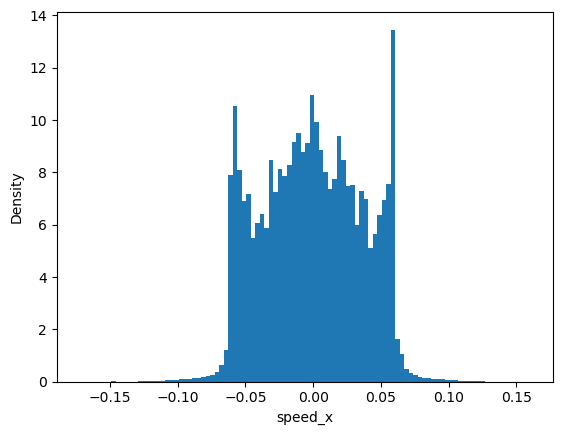

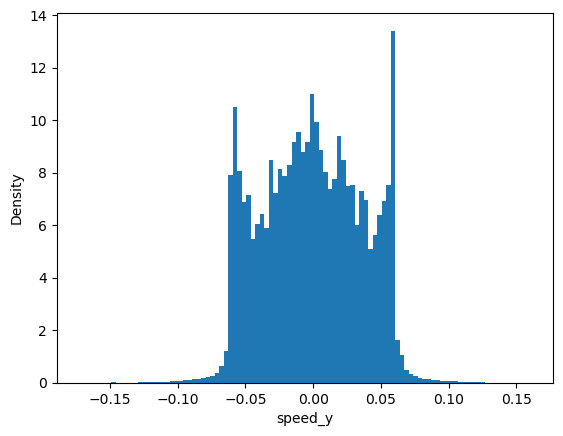

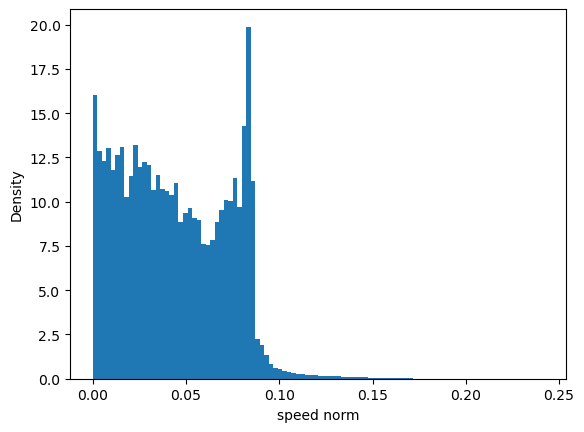

In [14]:
# s_x

speed_x = s[:, :, 0].view(-1).numpy()
plotDistr(speed_x, bins = 100, xlabel = 'speed_x', nameFile = f'{p_out}/speed_x.png')
plotDistr(speed_x, bins = 100, xlabel = 'speed_x')
# s_y

speed_y = s[:, :, 1].view(-1).numpy()
plotDistr(speed_y, bins = 100, xlabel = 'speed_y', nameFile = f'{p_out}/speed_y.png')
plotDistr(speed_y, bins = 100, xlabel = 'speed_y')
# norm of speed

speed = torch.sqrt(s[:, :, 0].view(-1) ** 2 + s[:, :, 1].view(-1) ** 2).numpy()
plotDistr(speed, bins = 100, xlabel = 'speed norm', nameFile = f'{p_out}/speed_norm.png')
plotDistr(speed, bins = 100, xlabel = 'speed norm')

### Degree distribution

In [15]:
from torch_geometric.utils import degree as deg

In [16]:
degs = torch.stack([deg(data[i].edge_index[0, :], num_nodes=data[i].x.size(0)) for i in range(len(data))]).view(-1).numpy()

In [17]:
print(np.min(degs))
print(np.max(degs))

0.0
5.0


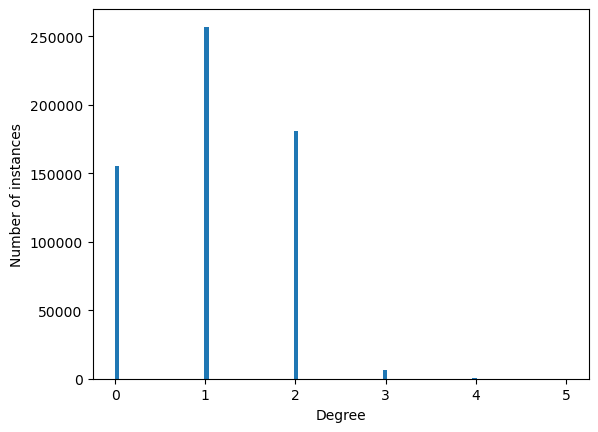

In [18]:
plotDistr(degs, bins = 'auto', density = False, xlabel = 'Degree', ylabel = 'Number of instances', nameFile = f'{p_out}/degree_hist.png')
plotDistr(degs, bins = 'auto', density = False, xlabel = 'Degree', ylabel = 'Number of instances')

### Distance distribution

In [19]:
def calculate_distances(graph):
    start_points = graph.x[graph.edge_index[0]]
    end_points = graph.x[graph.edge_index[1]]

    # Calculate the Euclidean distances
    distances = torch.sqrt(torch.sum((start_points - end_points) ** 2, dim=1))
    return distances

In [20]:
dist = []

for i in range(len(data)):
    dist.extend(calculate_distances(data[i]).numpy().tolist())
    
dist = np.array(dist)

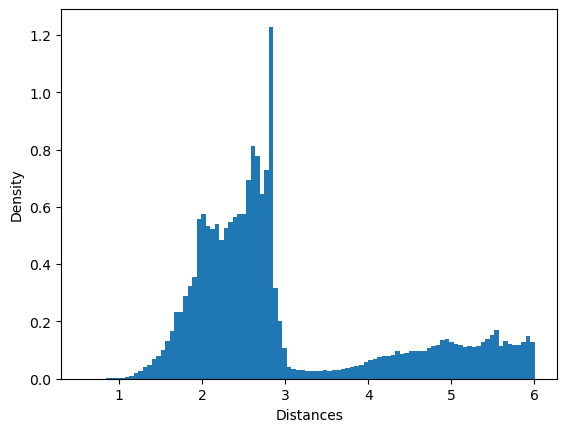

In [21]:
plotDistr(dist, bins = 100, xlabel = 'Distances', nameFile = f'{p_out}/dist_hist.png')
plotDistr(dist, bins = 100, xlabel = 'Distances')

### Interaction force

In [22]:
def calculate_interaction(dist, k, epsilon, radii = 1.0):
    """
    Given the vectors ri and rj, compute the force between them
    """


    bij = radii + radii

    if dist < bij*(1 + epsilon):
        force = k*(dist - bij)  
    elif dist < bij*(1 + 2*epsilon):
        force = -k*(dist - bij - 2*epsilon*bij)
    else:
        force = 0.0
    return force

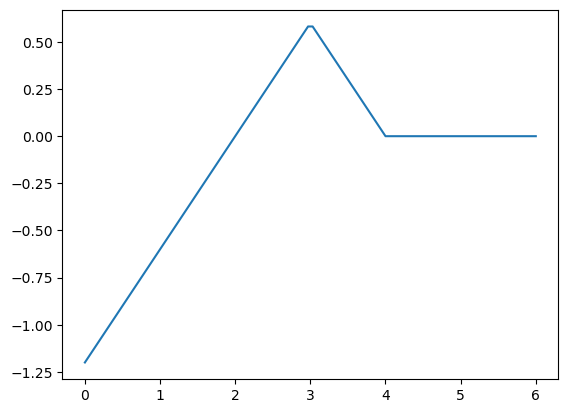

In [23]:
d = np.linspace(0, 6, 100)
k = 0.6
eps = 0.5
y = [calculate_interaction(d[i], k, eps) for i in range(len(d))]

plt.plot(d, y)
plt.show()

### Get videos